In [ ]:
#pip install medmnist

In [1]:
# Importing necessary libraries and dependencies
from medmnist import OCTMNIST

In [2]:
# Loading the dataset and preparing data loaders for training and validation
data = OCTMNIST

In [6]:
# Importing necessary libraries and dependencies
from torchvision import transforms

In [7]:
# Loading the dataset and preparing data loaders for training and validation
train = data(split="train", download = True, transform=transforms.ToTensor())
test = data(split="test", download = True, transform=transforms.ToTensor())
val = data(split="val", download = True, transform=transforms.ToTensor())

Using downloaded and verified file: /home/shwet/.medmnist/octmnist.npz
Using downloaded and verified file: /home/shwet/.medmnist/octmnist.npz
Using downloaded and verified file: /home/shwet/.medmnist/octmnist.npz


In [23]:
# Importing necessary libraries and dependencies
import medmnist
from medmnist import INFO, Evaluator

In [27]:
info = INFO['octmnist']
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [28]:
info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1',
 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf',
 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1',
 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae',
 'url_224': 'https://zenodo.org/records/10519652/files/octmnist_224.npz?downl

In [29]:
task

'multi-class'

In [30]:
n_channels

1

In [31]:
n_classes

4

In [34]:
batch = 64

In [33]:
# Importing necessary libraries and dependencies
from torch.utils.data import DataLoader

In [35]:
# Loading the dataset and preparing data loaders for training and validation
# encapsulate data into dataloader form
train_data = DataLoader(dataset=train, batch_size = batch, shuffle=True)
val_data = DataLoader(dataset=val, batch_size = 2 * batch, shuffle=False)
test_data = DataLoader(dataset=test, batch_size = 2 * batch, shuffle=False)

/home/shwet/anaconda3/lib/python3.9/site-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


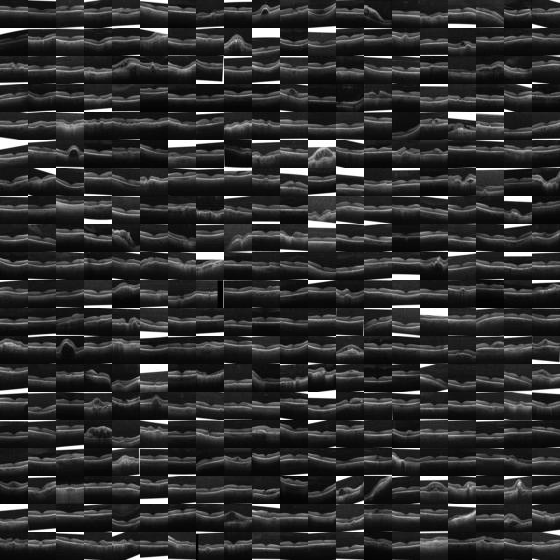

In [39]:
train.montage(20)

In [40]:
#let's design the NN

In [50]:
# Importing necessary libraries and dependencies
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Output: 16 x 14 x 14

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Output: 32 x 7 x 7

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())  # Output: 64 x 7 x 7
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Output: 128 x 3 x 3

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  # Output: 256 x 1 x 1

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling

        self.fc = nn.Sequential(
            nn.Linear(256 * 1 * 1, 128),  # Input size adjusted for global average pooling
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Dropout added
            nn.Linear(128, 64),  # New fully connected layer
            nn.ReLU(),
            nn.Dropout(p=0.4),  # Dropout added
            nn.Linear(64, 32),  # New fully connected layer
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout added
            nn.Linear(32, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.global_avg_pool(x)  # Apply global average pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

In [51]:
# Defining the deep learning model architecture
#Instantiate model
model = Net(in_channels = n_channels, num_classes = n_classes)

In [52]:
# Importing necessary libraries and dependencies
import torch.optim as optim

In [55]:
# Defining the deep learning model architecture
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [81]:
# Plotting training and validation metrics such as loss and accuracy
# Initialize best loss to a high value
best_val_loss = float('inf')

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [61]:
# Importing necessary libraries and dependencies
import torch
from sklearn.metrics import accuracy_score

In [83]:
# Loading the dataset and preparing data loaders for training and validation
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_data:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.squeeze()).sum().item()
    
    train_loss = running_loss / len(train_data)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_data:
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels.squeeze()).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy().squeeze())

    val_loss /= len(val_data)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print('Model saved!')
        break

Epoch [1/30], Loss: 0.0510, Accuracy: 98.35%
Validation Loss: 0.5188, Validation Accuracy: 91.53%
Epoch [2/30], Loss: 0.0535, Accuracy: 98.28%
Validation Loss: 0.4711, Validation Accuracy: 91.50%
Model saved!


In [84]:
# Loading the dataset and preparing data loaders for training and validation
# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Initialize counters for testing
correct = 0
total = 0
test_loss = 0.0

# Collect all predictions and labels for confusion matrix and other metrics
all_test_preds = []
all_test_labels = []

# Testing loop
model.eval()
with torch.no_grad():
    for inputs, labels in test_data:
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy().squeeze())


In [85]:
# Loading the dataset and preparing data loaders for training and validation
# Calculate overall test accuracy and loss
test_accuracy = round(100 * correct / total, 2)
test_loss = test_loss / len(test_data)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.8261, Test Accuracy: 73.30%


In [87]:
# Importing necessary libraries and dependencies
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

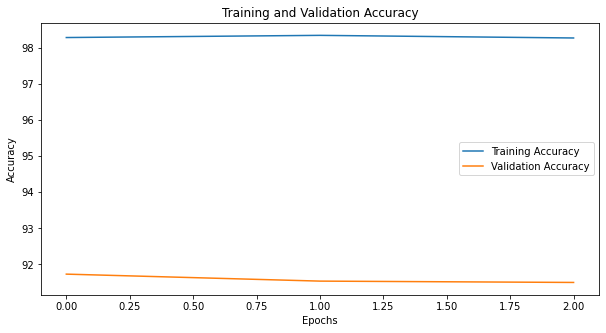

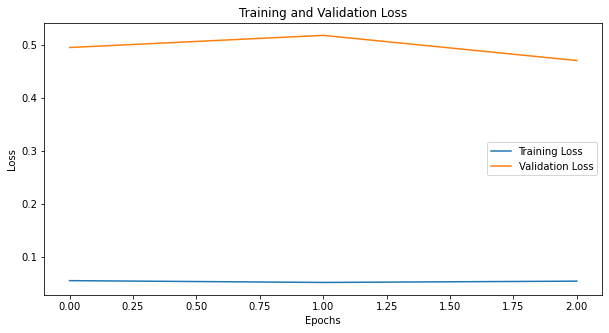

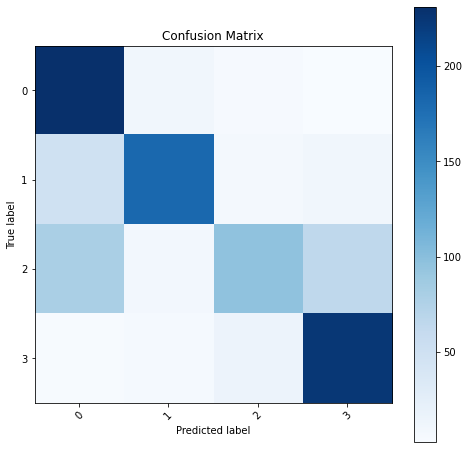

              precision    recall  f1-score   support

     Class 0       0.63      0.92      0.75       250
     Class 1       0.88      0.73      0.79       250
     Class 2       0.77      0.38      0.51       250
     Class 3       0.74      0.90      0.81       250

    accuracy                           0.73      1000
   macro avg       0.75      0.73      0.72      1000
weighted avg       0.75      0.73      0.72      1000

Precision: 0.7542
Recall: 0.7330
F1 Score: 0.7173


In [90]:
# Plotting training and validation metrics such as loss and accuracy
# Convert lists to numpy arrays for plotting and evaluation
all_test_preds = np.array(all_test_preds)
all_test_labels = np.array(all_test_labels)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, tick_marks, rotation=45)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculate and print classification report
report = classification_report(all_test_labels, all_test_preds, target_names=[f'Class {i}' for i in range(n_classes)])
print(report)

# Calculate and print additional metrics: precision, recall, and F1 score
precision = precision_score(all_test_labels, all_test_preds, average='macro')
recall = recall_score(all_test_labels, all_test_preds, average='macro')
f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')